<a href="https://colab.research.google.com/github/liuxx479/pzCOSMOS/blob/main/prep_kappaTNG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
from pylab import *
import os
from scipy.interpolate import interp1d
from scipy.integrate import quad
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root = '/content/drive/My Drive/pzCOSMOS/'

In [62]:
pz=np.load(root+'pz.npy')
zs=np.load(root+'z_sources.npy')

zs_full = np.linspace(0, 5, 101)
pz_full = interp1d(zs, pz, fill_value="extrapolate")(zs_full)
pz_full[pz_full<0]=0
# dndz_interp = interp1d(zs_full, pz_full)

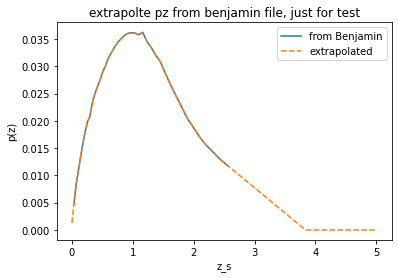

In [83]:
plot(zs,pz,label='from Benjamin')
plot(zs_full, pz_full,'--',label='extrapolated')
xlabel('z_s')
ylabel('p(z)')
legend()
title('extrapolte pz from benjamin file, just for test')
show()

In [64]:

######## planck parameters

# LCDM parameters
A_s = 2.142e-9
h=0.6774
OmegaB = 0.0486
OmegaM = 0.3089
n_s = 0.9667

### derived parameters
ombh2 = OmegaB*h**2
omch2 = (OmegaM-OmegaB)*h**2
H0=h*100

OmegaV = 1.0-OmegaM
c = 299792.458 #km/s
H_inv = lambda z: 1.0/(H0*sqrt(OmegaM*(1+z)**3+OmegaV))
DC = lambda z: c*quad(H_inv, 0, z)[0] # comoving distance Mpc

def lensing_kernel(zs, pz, z_arr=zs_full):
  dndz_interp = interp1d(zs, pz)
  integrand = lambda zs, z: dndz_interp(zs)*(1-DC(z)/DC(zs))
  W_wl_fcn = lambda z: 1.5*OmegaM*H0**2*(1+z)*H_inv(z)*DC(z)/c*quad(integrand, z, 5.0, args=(z,))[0]
  W_wl = array([W_wl_fcn(z) for z in z_arr])
  # W_wl = map(W_wl_fcn, z_arr)
  return W_wl

In [65]:
W_original = lensing_kernel(zs_full, pz_full)
# print (W_original)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


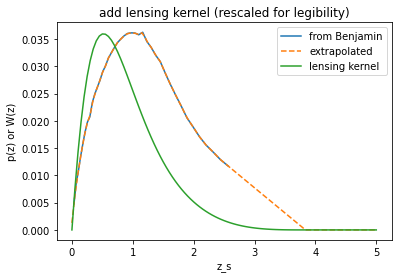

In [87]:
plot(zs,pz,label='from Benjamin')
plot(zs_full, dndz_interp (zs_full),'--',label='extrapolated')
# plot(zs_full, pz_mod,'-',label='modified')
plot(zs_full, W_original*5,'-',label='lensing kernel')
xlabel('z_s')
ylabel('p(z) or W(z)')
legend()
title('add lensing kernel (rescaled for legibility)')
show()

In [71]:
######## next, I modify the pz, such that all z>2.6 galaxies are placed at z=2.6
idx=int(where(zs_full==2.6)[0])
pz_mod = pz_full.copy()
pz_mod[idx] = sum(pz_full[idx+1:])
pz_mod[idx+1:]=0
W_mod = lensing_kernel(zs_full, pz_mod)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


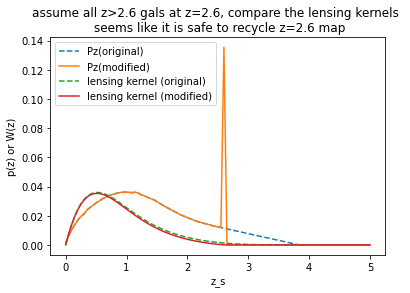

In [86]:
plot(zs_full, dndz_interp (zs_full),'--',label='Pz(original)')
plot(zs_full, pz_mod,'-',label='Pz(modified)')
plot(zs_full, W_original*5,'--',label='lensing kernel (original)')
plot(zs_full, W_mod*5,'-',label='lensing kernel (modified)')
xlabel('z_s')
ylabel('p(z) or W(z)')
legend()
title('assume all z>2.6 gals at z=2.6, compare the lensing kernels \n seems like it is safe to recycle z=2.6 map')
show()